In [64]:
import pandas as pd
import yaml
import torch
import os
from pytorch_lightning import Trainer, seed_everything
from eyemind.trainer.loops import KFoldLoop
import eyemind
from eyemind.models.transformers import InformerEncoderDecoderModel, InformerEncoderFixationModel, InformerMultiTaskEncoderDecoder
from eyemind.dataloading.informer_data import InformerDataModule
import matplotlib.pyplot as plt

# Overview
Simply load in already-trained models and generate predictions

This shouldn't be this difficult!

# Notes


in the original informer code, there is a command line option
`parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')`
Check what this does

## encoder only
I have managed to get logits from the encoder, but model(batch) does not work when mdoel is the entire multitask enc-decoder stack.

## fixation decoder
How to load this? 
A: model.fi_decoder

# TODO ideas
[x] try loading encoder and fi decoder separately

[ ] try modifying train loop to store the preds per batch

[ ] within loop, get batch and run thru 2 models - ensure same random subsequence chosen




In [65]:
import matplotlib.patches as mpatches

def fixation_image(pred,target, title="Fixation Identification"):
    sl = len(pred)
    print(f'sequence length: {sl}')
    fixation_labels = torch.cat((pred.expand(sl//2,sl),target.expand(sl//2,sl)))
    plt.imshow(fixation_labels, extent=[0, len(fixation_labels[1]),0, 100], cmap='Greys')
    # plt.xticks(np.arange(0, len(fixation_labels), 1), [])
    plt.yticks([])
    # plt.grid(True, axis='x', lw=1, c='black')
    # plt.tick_params(axis='x', length=0)
    plt.title(title)
    black = mpatches.Patch(color='black', label='Fixation')
    white = mpatches.Patch(color='white', label='Saccade')
    plt.legend(handles=[black, white],bbox_to_anchor=(1.15, 1), loc='upper right')
    plt.xlabel("Time Steps (100 steps ~ 1.7s)")
    plt.show()

In [48]:
# Load our trained encoder decoder from checkpoint for each fold
# this shouold load the encoder and its 4 decoders

# using pytorch lightning module
# https://lightning.ai/docs/pytorch/stable/deploy/production_basic.html

repodir = os.path.dirname(os.path.dirname(eyemind.__file__))

for fold in [0, 1, 2, 3]:
    save_dir = f"{repodir}/lightning_logs/informer_pretraining_seed21/fold{fold}/"
    config_path=os.path.join(save_dir,"config.yaml")
    ckpt_path = os.path.join(save_dir,"checkpoints","last.ckpt")
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    seed_everything(config["seed_everything"], workers=True) # not sure if this is needed

    model = InformerMultiTaskEncoderDecoder.load_from_checkpoint(ckpt_path,
                                                    # encoder_weights_path=None
                                                    )
    encoder=model.encoder
    decoder=model.fi_decoder
    model.eval()
    encoder.eval()
    decoder.eval()
    
    # set up an InformerDataModule to load the same data as used in training
    # trainer = Trainer(**config["trainer"])
    data_dir = os.path.join(repodir,config["data"]["data_dir"])
    label_file = os.path.join(repodir,config["data"]["label_filepath"])
    config["data"]["data_dir"]=data_dir
    config["data"]["label_filepath"]=label_file
    
    datamodule = InformerDataModule(**config["data"])
    datamodule.setup()

    test_dl = datamodule.get_dataloader(datamodule.test_dataset) # this is the held out fold's dataloader
    for i,batch in enumerate(test_dl):
        print(f"batch: {i}")
        print(f"length of batch: {len(batch)}")
        with torch.no_grad():
            # preds = model(batch) # this step fails
            logits=encoder(batch[0], None)
            fixation_logits = model.fi_decoder.forward(logits)
            fixation_preds=fixation_logits.max(2).indices
            fixation_targets = batch[1]

        if i==4: # just run a couple to check
            break


Global seed set to 21
/usr/local/Caskroom/miniconda/base/envs/dg/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


batch: 0
length of batch: 4
preds: torch.Size([32, 500, 2])


TypeError: new(): invalid data type 'str'

In [47]:
# Try running encoder on batch
# batch size is 32
# but batch contains 4 elements each of length 32

with torch.no_grad():
    print((len(batch)))
    print(batch[0].shape) # <- sequence
    print(batch[1].shape) # <- fixation targets, but we want to pretend we don't know these! is that "x_dec" ?
    # print(batch[1][0:10]) # Contains 0 and 1
    print(batch[2].shape) # <- second sequence for contrastive??
    print(batch[3].shape) # <- Some binary label per instance

    logits2 = encoder.forward(batch[0], batch[1]) # this works, but batch[1] contains the labels when we are trying to predict them.
    logits = encoder.forward(batch[0], None) # this works, setting the labels to None. Hooray! 
    if torch.equal(logits2, logits):
        print('providing labels made no difference')
    else:
        print('removing labels changed the predicitons')

    print(f'logits shape: {logits.shape}')


4
torch.Size([32, 500, 2])
torch.Size([32, 500])
torch.Size([32, 500, 2])
torch.Size([32])
removing labels changed the predicitons
logits shape: torch.Size([32, 500, 512])


In [ ]:
# # We can see the attributes of the full model using dir
# dir(model)
# # it has a module list of decoders
# dir(model.decoders)

# Apart from pc we can access each task's decoder like so:
print(f'FI decoder: {model.fi_decoder}')
print(f'RC decoder: {model.rc_decoder}')
print(f'CL decoder: {model.cl_decoder}')

FI logits: torch.Size([32, 500, 2])
tensor([[1, 0, 0,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 1, 1, 0],
        ...,
        [0, 1, 1,  ..., 1, 0, 0],
        [0, 1, 1,  ..., 1, 0, 1],
        [0, 1, 1,  ..., 1, 1, 0]])
torch.Size([500])
torch.Size([500])
sequence length: 500


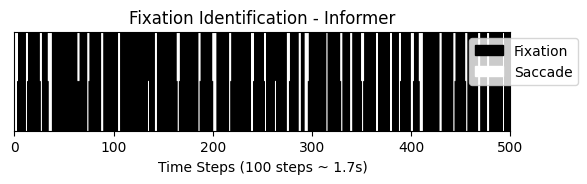

In [70]:
# Great! Let's use the logits from the encoder as input to the fi decoder...
fixation_logits = model.fi_decoder.forward(logits)
print(f"FI logits: {fixation_logits.shape}")
# this is of shape n, len, 2. I assume the 2 dimensions here are prob(fix) and prob(sacc)? 
# do we need to just take one dimension? And softmax then threshold >/5?
fixation_preds=fixation_logits.max(2).indices
print(fixation_preds)
fixation_targets = batch[1]

# or reshape batch into one long vector in Ricks's code, to get batch-wisemetric:
logits_long = fixation_logits.squeeze().reshape(-1,2)
targets_long = fixation_targets.reshape(-1).long()

# pick one from batch to plot
one_pred = fixation_preds[0,:]
one_target = fixation_targets[0,:]
print(one_pred.shape)
print(one_target.shape)

fixation_image(one_pred, one_target, "Fixation Identification - Informer")

# SUCCESS!!


In [68]:
# evaluate FI 

#mask = torch.any(X == -180, dim=1)
loss = self.fi_criterion(logits_long, targets_long)
preds = self._get_preds(logits)
probs = self._get_probs(logits)
targets = targets.int()
auprc = model.fi_metric(probs, targets)

NameError: name 'torchmetrics' is not defined

In [71]:
model.fi_metric
model._get_preds # TODO: use this to get predictions from logits
model._get_probs # TODO: use this to get probs from logits

<bound method InformerMultiTaskEncoderDecoder._get_preds of InformerMultiTaskEncoderDecoder(
  (encoder): InformerEncoder(
    (enc_embedding): GazeEmbedding(
      (value_embedding): TokenEmbedding(
        (tokenConv): Conv1d(2, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
      )
      (position_embedding): PositionalEmbedding()
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encoder): Encoder(
      (attn_layers): ModuleList(
        (0): EncoderLayer(
          (attention): AttentionLayer(
            (inner_attention): ProbAttention(
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (query_projection): Linear(in_features=512, out_features=512, bias=True)
            (key_projection): Linear(in_features=512, out_features=512, bias=True)
            (value_projection): Linear(in_features=512, out_features=512, bias=True)
            (out_projection): Linear(in_features=512, out_features=512, bias=True)
         